# Ideas
    1. Download many stock datasets OK
    2. Display nicely those stock datasets Almost OK
    3. Make some data preprocessing - like values only from -1 to 1or sth
    4. Implement some prediction-like algorithms
    5. Make and display predictions
    6. Make and display future predictions :o

## Imports and Some Settings

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.optimizers as opti
import tensorflow.keras.activations as acti
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import pandas_datareader
from datetime import date
from sklearn.preprocessing import MinMaxScaler

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Some Consts and "Consts"

In [84]:
# Super Hiper Important - Names and "Short Names" of Companies to get their stock prices from web
COMPANIES = {"Apple Inc.": "AAPL",
                  "Tesla Inc.": "TSLA",
                  "Netflix Inc.": "NFLX",
                  "Amazon.com Inc.": "AMZN",
                  "Alphabet Inc.": "GOOG",
                  "Facebook Inc.": "FB"}

# Consts
DATA_SRC = 'yahoo'
START_DATE = '2012-01-01'
DEFAULT_VAL_DAYS = 200
DEFAULT_SCALERS = [MinMaxScaler(feature_range=(0, 1)) for ii in range(len(COMPANIES))]
DEFAULT_LEARN_SIZE = 60
DEFAULT_INPUT_SHAPE = (DEFAULT_LEARN_SIZE, 1)

# Almost Const
END_DATE = date.today().strftime("%Y-%m-%d")

## Loading Datasets

In [85]:
def read_dataset_from_web(dataset_short, data_src=DATA_SRC, start_date=START_DATE, end_date=END_DATE):
    return pandas_datareader.DataReader(dataset_short, data_source=data_src, start=start_date, end=end_date) 

In [86]:
all_raw_datasets = [read_dataset_from_web(COMPANIES[name_short]) for name_short in COMPANIES]
datasets = [buf.filter(['Close']).values for buf in all_raw_datasets]

## Displaying Real Datasets

In [87]:
def display_datasets(sets, datasets, names, title, xlabel, ylabel):
    """
    Displays given datasets
    :param sets: size of figure and position for subplots
    :param datasets: list of datasets
    :param names: names of the companies
    :param title: top title of subplot
    :param xlabel: text for xlabel :o
    :param ylabel: text for ylabel :o
    """
    sub = fig.add_subplot(sets[0], sets[1], sets[2])
    sub.set_title(title, fontsize=24)
    sub.set_xlabel(xlabel, fontsize=20)
    sub.set_ylabel(ylabel, fontsize=20)
    
    for ii in range(len(datasets)):
        y = datasets[ii]
        label = names[ii]
        sub.plot(y, label=label)
    sub.legend(fontsize=16)
    sub.grid()

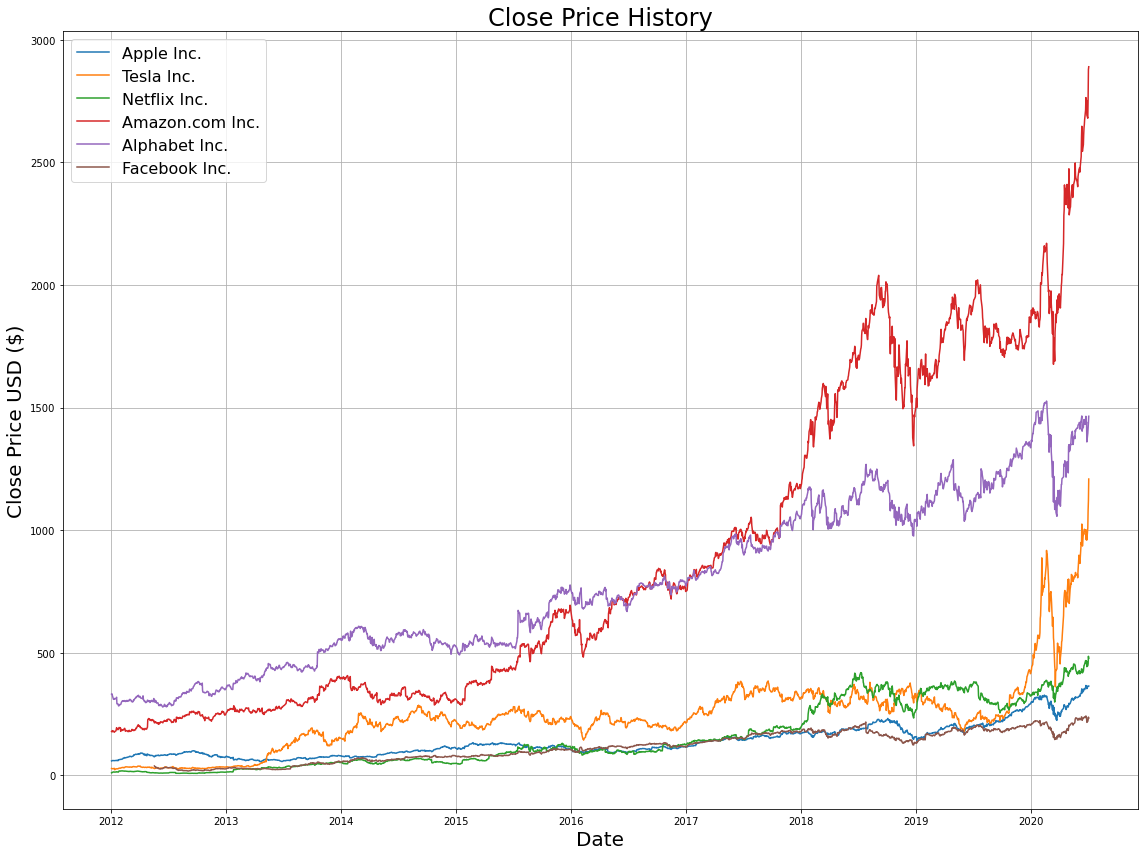

In [88]:
all_raw_datasets_close = [buf['Close'] for buf in all_raw_datasets]
fig = plt.figure(figsize=(16, 12))
display_datasets((1,1,1), all_raw_datasets_close, list(COMPANIES.keys()), 'Close Price History', 'Date', 'Close Price USD ($)')
plt.tight_layout()
plt.draw()

## Data Preprocessing and Splitting into Train/Val Datasets

In [89]:
def split_dataset(dataset, val_days=DEFAULT_VAL_DAYS, part=None):
    if part:
        train_size = int(np.ceil(dataset.shape[0] * part))
        train = dataset[:train_size]
        val = dataset[train_size:]
    else:    
        val = dataset[-DEFAULT_VAL_DAYS:]
        train = dataset[:-DEFAULT_VAL_DAYS]

    return train.reshape((train.shape[0], train.shape[1], 1)), val.reshape((val.shape[0], val.shape[1], 1))

In [90]:
def split_dataset_into_x_and_y_sets(dataset):
    X = []
    y = []
    for ii in range(DEFAULT_LEARN_SIZE,dataset.shape[0]):
        X.append(dataset[ii-DEFAULT_LEARN_SIZE:ii])
        y.append(dataset[ii])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0],X.shape[1],1))
    return X, y

In [91]:
datasets_norm = [DEFAULT_SCALERS[ii].fit_transform(datasets[ii]) for ii in range(len(COMPANIES))]
datasets_split = [split_dataset(ds, part=0.8) for ds in datasets_norm]
datasets_split_xy = [(split_dataset_into_x_and_y_sets(train), split_dataset_into_x_and_y_sets(val)) for train, val in datasets_split]
datasets_final = {list(COMPANIES.keys())[ii]: datasets_split_xy[ii] for ii in range(len(COMPANIES))} 

## Some Models 

In [65]:
def generate_model(lstm_units, dense_units, input_shape):
    model = tf.keras.Sequential()
    # new LSTM layers
    for ii in range(len(lstm_units)):
        if ii+1 != len(lstm_units):
            buf_layer = layers.LSTM(units=lstm_units[ii], return_sequences=True, input_shape=(input_shape))
        else:
            buf_layer = layers.LSTM(units=lstm_units[ii], return_sequences=False)
        model.add(buf_layer)  
    # new Dense layers      
    for ii in range(len(dense_units)):
        buf_layer = layers.Dense(units=dense_units[ii])
        model.add(buf_layer)
    return model

In [66]:
simple_model = generate_model([50, 50], [25, 1], DEFAULT_INPUT_SHAPE)
simple_model.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
simple_models = [generate_model([50, 50], [25, 1], DEFAULT_INPUT_SHAPE) for ii in range(len(COMPANIES))]
for model in simple_models: model.compile(optimizer='adam', loss='mean_squared_error')

## Training / Fitting Models

In [71]:
for ii in range(len(COMPANIES)):
    X = datasets_split_xy[ii][0][0]
    y = datasets_split_xy[ii][0][1]
    model = simple_models[ii]
    model.fit(X, y, batch_size=1, epochs=1, verbose=1)

1576/1576 [==============================] - 7s 4ms/step - loss: 7.2410e-04


## Evaluating Models - Predictions

In [92]:
predictions = list()
for ii in range(len(COMPANIES)):
    X = datasets_split_xy[ii][1][0]
    model = simple_models[ii]
    result = model.predict(X, verbose=1)
    predictions.append(result)

predictions = [DEFAULT_SCALERS[ii].inverse_transform(predictions[ii]) for ii in range(len(COMPANIES))]

11/11 [==============================] - 0s 3ms/step


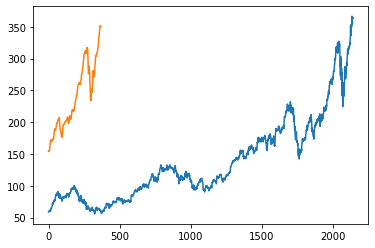

In [97]:
plt.plot(all_raw_datasets_close[0].values)
plt.plot(predictions[0])
plt.show()

## Predictions for Future :o